In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../Dataset/VCB-Historical-Data_Group-9.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Chuyển các giá trị trong cột về number
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [4]:
df1=df.reset_index()['Price']

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 25s 305ms/step - loss: 0.0834 - val_loss: 0.0041
Epoch 2/100
14/14 [==============================] - 1s 37ms/step - loss: 0.0139 - val_loss: 0.0153
Epoch 3/100
14/14 [==============================] - 1s 43ms/step - loss: 0.0065 - val_loss: 0.0196
Epoch 4/100
14/14 [==============================] - 1s 39ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 5/100
14/14 [==============================] - 1s 48ms/step - loss: 0.0036 - val_loss: 0.0074
Epoch 6/100
14/14 [==============================] - 0s 36ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 7/100
14/14 [==============================] - 1s 46ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 8/100
14/14 [==============================] - 1s 41ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/100
14/14 [==============================] - 1s 51ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/100
14/14 [==============================] - 1s 62ms/step - loss: 0.0012 - val_loss: 7.57

In [13]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)


12/12 [==============================] - 0s 7ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_test
train_predict=scaler.inverse_transform(train_predict)
y_pred_=scaler.inverse_transform(y_pred)
y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

In [15]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[30:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_30 = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i = i + 1

In [16]:
# 13. Dự báo 60 ngày tiếp theo 

x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0

while i < 60:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1

In [17]:
# 14. Dự báo 90 ngày tiếp theo
x_input = test_data[90:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

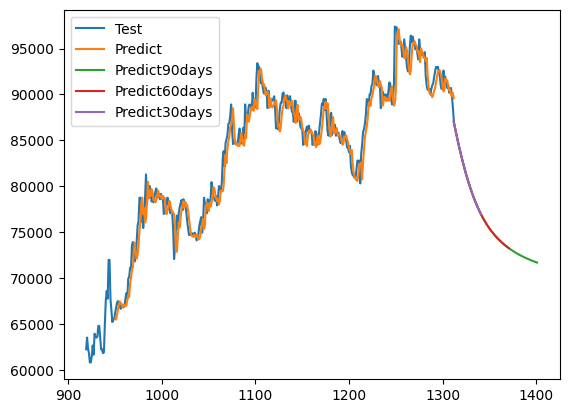

In [18]:
# 15.Vẽ hình dự báo 90 ngày tiếp theo

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred_))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_90))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_60))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_30))
plt.legend(['Test','Predict','Predict90days','Predict60days','Predict30days'])
plt.show()

In [19]:
# 16.Đánh giá thuật toán

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100

print('RMSE', test_score_rmse)
print('MAPE', test_score_mape)
# Tính MAE (Mean Absolute Error)
test_mae = np.mean(np.abs(y_test_new - y_pred_new))
print('MAE:', test_mae)


RMSE 1164.359
MAPE 1.017458550632
MAE: 857.2915
